In [1382]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV, Lasso, LassoCV
from sklearn.decomposition import PCA

import seaborn as sns

%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

warnings.filterwarnings('ignore')

#### Datasets

In [1383]:
import os
for dirname, _, filenames in os.walk('./input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
 

./input/real_estate_price_prediction_moscow\gb_submit.csv
./input/real_estate_price_prediction_moscow\sample_submission.csv
./input/real_estate_price_prediction_moscow\test.csv
./input/real_estate_price_prediction_moscow\train.csv


In [1384]:
    TRAIN_DATASET_PATH = './input/real_estate_price_prediction_moscow/train.csv'
    TEST_DATASET_PATH = './input/real_estate_price_prediction_moscow/test.csv'

#### Auxiliary functions

In [1385]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 4)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 4)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [1386]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

#### Loading Train and Test

In [1387]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
test_df = pd.read_csv(TEST_DATASET_PATH, sep=',')

train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


In [1388]:
print(f'Strings in train: {train_df.shape[0]}')
print(f'Strings in test: {test_df.shape[0]}')

Strings in train: 10000
Strings in test: 5000


In [1389]:
# check the number of columns (train have col=Price --> target)
train_df.shape[1] - test_df.shape[1] == 1

True

#### Target distribution

In [1390]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,10000.0,8383.407700,4859.019020,0.000000,4169.500000,8394.500000,12592.500000,1.679800e+04
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,2.090000e+02
Rooms,10000.0,1.890500,0.839522,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315720,21.058716,1.136859,41.774879,52.513309,65.900627,6.410652e+02
LifeSquare,7887.0,37.199665,86.241219,0.370619,22.769833,32.781261,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560839,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.776200,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218670e-01


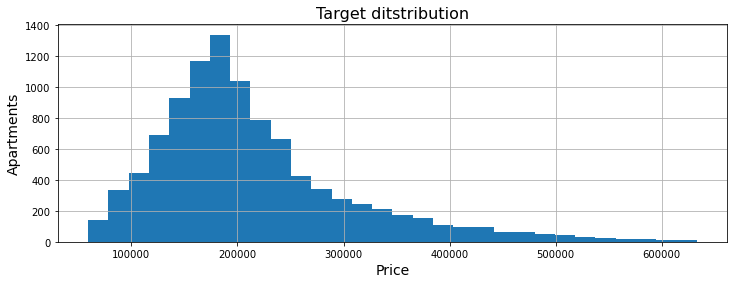

In [1391]:
plt.figure(figsize=(12, 4))
train_df['Price'].hist(bins=30)
plt.xlabel('Price', fontsize=14)
plt.ylabel('Apartments', fontsize=14)
plt.title('Target ditstribution', fontsize=16)

plt.show()

#### Correlation

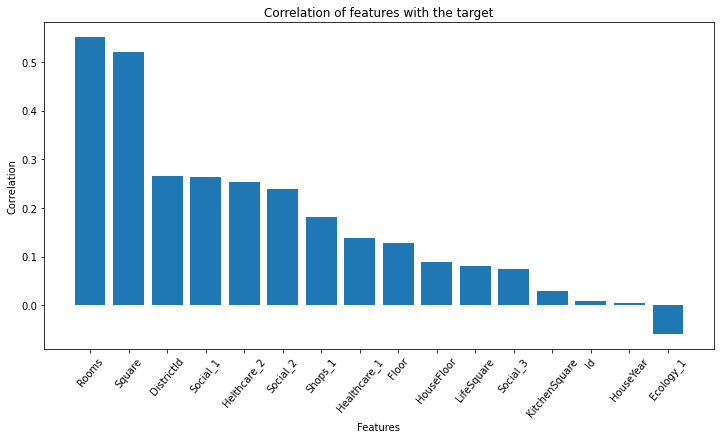

In [1392]:
correlation = train_df.corrwith(train_df['Price']).sort_values(ascending=False)
correlation.drop('Price', inplace=True)

plt.figure(figsize=(12, 6))
plt.bar(correlation.index, correlation)
plt.xticks(rotation=50)
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.title('Correlation of features with the target')

plt.show()

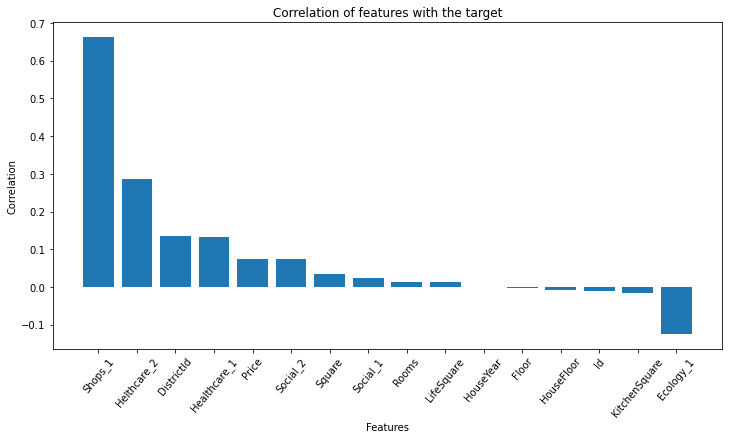

In [1393]:
correlation = train_df.corrwith(train_df['Social_3']).sort_values(ascending=False)
correlation.drop('Social_3', inplace=True)

plt.figure(figsize=(12, 6))
plt.bar(correlation.index, correlation)
plt.xticks(rotation=50)
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.title('Correlation of features with the target')

plt.show()

In [1394]:
train_df['Id'] = train_df['Id'].astype(str)
train_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.718750
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.000000
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.093750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090729,33.272625,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.453125
9996,16265,27,2.0,64.307686,37.038422,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.156250
9997,2795,178,1.0,29.648056,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.906250
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.406250


### Emissions

#### Numerical features

In [1395]:
num_f = list(train_df.select_dtypes(exclude='object').columns)

#### Categorical features

In [1396]:
str_f = list(train_df.select_dtypes(include='object').columns)

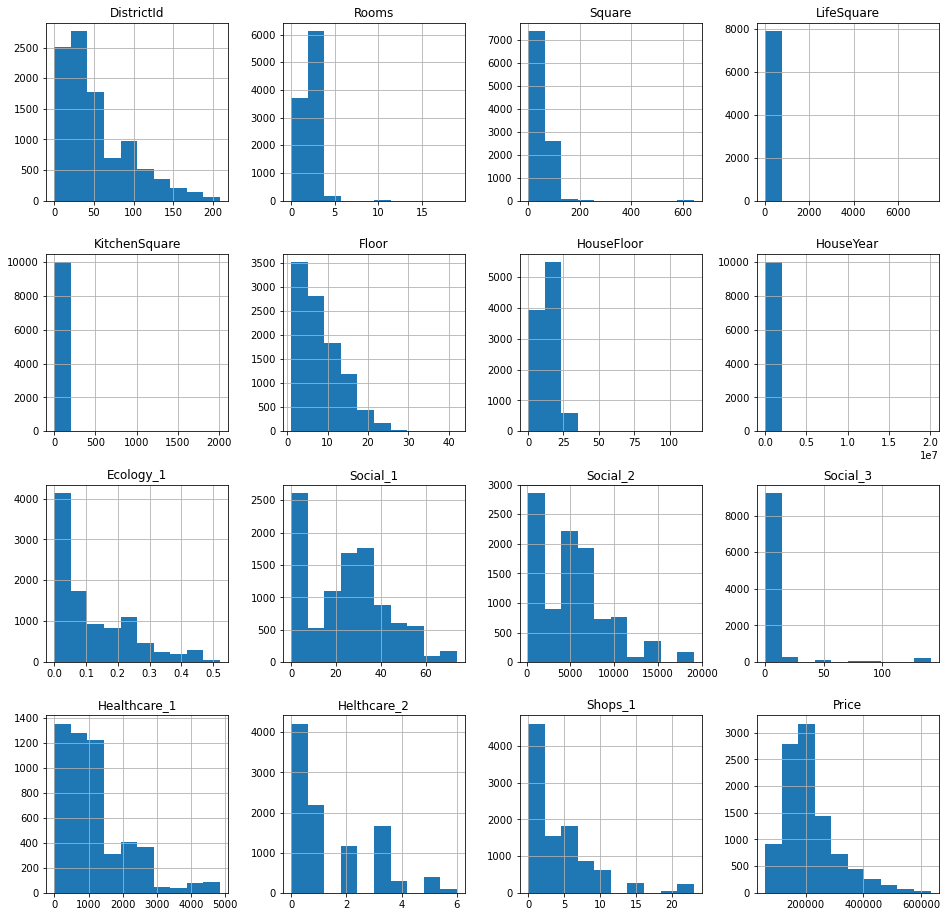

In [1397]:
train_df[num_f].hist(figsize=(16, 16))
plt.show()

### DataPreprocessor

In [1398]:
class DataPreprocessor:
    
    def __init__(self):
        self.medians = None
        self.min_kitchen_square = None
        self.districts_healthcare = None
        self.mean_h1_district = None
        self.med_kitchen_district = None
        self.med_life_sq_dist_rm = None

    
    def fit(self, X):
        # Medians, means, min
        self.medians = X.median()
        
        self.min_kitchen_square = np.quantile(X['KitchenSquare'], q=0.001)
        
        self.mean_h1_district = X.groupby('DistrictId')['Healthcare_1'].mean().to_dict()
        
        self.med_kitchen_district = X.groupby('DistrictId')['KitchenSquare'].median().to_dict()
        
        self.med_life_sq_dist_rm = X.groupby(['DistrictId', 'Rooms'], as_index=False)['LifeSquare'].median()\
        .rename(columns={'LifeSquare': 'life_id_room_median'})
        
    def transform(self, X):
        # LifeSquare
        
        ## add column with median LifeSquare by DistrictId and Rooms
        X = X.merge(self.med_life_sq_dist_rm, on=['DistrictId', 'Rooms'], how='left')
        
        condition_life = X['LifeSquare'].isna()
        ## NaN --> LifeSquare = life_id_room_median
        X.loc[condition_life, 'LifeSquare'] = X.loc[condition_life, 'life_id_room_median']

        ## NaN (if 'life_id_room_median' = NaN) --> 0.92 * Square - Kitchen
        X['LifeSquare'].fillna(X['Square'] * .92 - X['KitchenSquare'], inplace=True)

        
        # Rooms
        condition_rooms = (X['Rooms'] >= 6) | (X['Rooms'] == 0)
        
        ## Square of the room
        rooms_district = X.groupby(['DistrictId'])['Rooms']
        room_sq_median =  X['LifeSquare'].median() / self.medians['Rooms']
        X.loc[condition_rooms, 'Rooms'] =  X.loc[condition_rooms, 'LifeSquare'] / room_sq_median

        
        # Square

        ## Square < KitchenSquare --> Square <=> KitchenSquare (if KitchenSquare <= 250 (--> for Square this max))
        X['Square'], X['KitchenSquare'] = np.where(
            (X['Square'] <= X['KitchenSquare']) & (X['KitchenSquare'] <= 250),
            (X['KitchenSquare'], X['Square']), (X['Square'], X['KitchenSquare'])
        )

        ## Square < LifeSquare --> Square <=> LifeSquare 
        X['Square'], X['LifeSquare'] = np.where(
            X['Square'] < X['LifeSquare'], (X['LifeSquare'], X['Square']), (X['Square'], X['LifeSquare'])
        )
        
        
        # KitchenSquare
        ## Outliers --> Square - LifeSquare - 3
        condition_kitchen_square = (X['KitchenSquare'] > 60) | (X['KitchenSquare'] < self.min_kitchen_square)

        X.loc[condition_kitchen_square, 'KitchenSquare'] = \
        X.loc[condition_kitchen_square, 'Square'] - X.loc[condition_kitchen_square, 'LifeSquare'] - 3
        
        
        # Ecology and Shops
        ## Switch to binary
        binary_to_numbers = {'A': 0, 'B': 1}
        
        X.replace({
            'Ecology_2': binary_to_numbers,
            'Ecology_3': binary_to_numbers,
            'Shops_2': binary_to_numbers
        }, inplace=True)
        
        
        # Floor
        ## Min Floor
        train_df.loc[train_df['Floor'] < 1, 'Floor'] = 1
        
        
        # HouseFloor
        ## HouseFloor < Floor --> HouseFloor = Floor
        condition_house_floor = X['HouseFloor'] < X['Floor'] 
        X.loc[condition_house_floor, 'HouseFloor'] = X.loc[condition_house_floor, 'Floor']


        # HouseYear
        ## HouseYear > current year --> median year
        condition_year = X['HouseYear'] > 2021
        X.loc[condition_year, 'HouseYear'] = self.medians['HouseYear']
        
        
        # Healthcare_1
        X.loc[X['Healthcare_1'].isna(), 'Healthcare_1'] = X['DistrictId'].map(self.mean_h1_district)
        X['Healthcare_1'].fillna(self.medians['Healthcare_1'], inplace=True)
        healthcare_1_quntile_max = np.quantile(X['Healthcare_1'], q=0.95)
        X.loc[X['Healthcare_1'] > healthcare_1_quntile_max, 'Healthcare_1'] = healthcare_1_quntile_max 
    
        # remove cols
        X.drop(columns=['Id', 'life_id_room_median'], inplace=True)
    
    
        # Fillna
        X.fillna(self.medians, inplace=True)

    
        return X

### FeatureGenerator

In [1399]:
class FeatureGenerator:
    
    def __init__(self):
        self.district_median_year = None
        self.district_density = None
        self.district_price_square = None
        self.min_square = None
        self.max_square = None
        self.district_size = None
        self.median_district_size = None
        self.healthcare_1_min = None
        self.healthcare_1_max = None
        self.shops_1_max = None
    
    def fit(self, X, y=None):
        X = X.copy()
        
        self.district_size = X['DistrictId'].value_counts().reset_index() \
        .rename(columns={'index': 'DistrictId', 'DistrictId': 'DistrictSize'})
        
        self.median_district_size = self.district_size['DistrictSize'].median()
        
        self.district_median_year = X.groupby('DistrictId')['HouseYear'].median().to_dict()
        self.district_median_square = X.groupby('DistrictId')['Square'].median().to_dict()
        self.district_median_social_1 = X.groupby('DistrictId')['Social_1'].median().to_dict()
        
        self.shops_1_median_social_3 = X.groupby('Shops_1')['Social_3'].median().to_dict()

        self.min_square = np.quantile(X['Square'], q=0.005)
        self.max_square = np.quantile(X['Square'], q=0.9994)\
        
        self.healthcare_1_max = X['Healthcare_1'].max()
        self.shops_1_max = X['Shops_1'].max()
        
        # Target encoding
        if y is not None:
            df = X.copy()
            df['Price'] = y.values
            
            self.district_price_square = \
            df.groupby('DistrictId')['Price'].median() / df.groupby('DistrictId')['Square'].median()
            
            self.district_price_lifesquare = \
            df.groupby('DistrictId')['Price'].median() / df.groupby('DistrictId')['LifeSquare'].median()

        
        
    def transform(self, X):
        # DistrictSize
        X = X.merge(self.district_size, on='DistrictId', how='left')
        X.loc[X['DistrictSize'].isna(), 'DistrictSize'] = self.median_district_size
        
        # DistrictYear
        X['DistrictYear'] = X['DistrictId'].map(self.district_median_year)
        
        self.median_district_year = X['DistrictYear'].median()
        X['DistrictYear'].fillna(self.median_district_year, inplace=True)
        
        # DistrictSquare
        X['DistrictSquare'] = X['DistrictId'].map(self.district_median_square)
        
        self.median_district_square = X['DistrictSquare'].median()
        X['DistrictSquare'].fillna(self.median_district_square, inplace=True)
        
        # DistrictSocial_1
        X['DistrictSocial_1'] = X['DistrictId'].map(self.district_median_social_1)
        
        self.median_district_social_1 = X['DistrictSocial_1'].median()
        X['DistrictSocial_1'].fillna(self.median_district_social_1, inplace=True)
        
        # Shops_1Social_3
        
        X['Shops_1Social_3'] = X['Shops_1'] + X['Social_3']
        
        # DistrictPriceSquare
        self.district_price_square.to_dict()
        X['DistrictPriceSquare'] = X['DistrictId'].map(self.district_price_square)
        
        self.median_district_price_square = X['DistrictPriceSquare'].median()
        X['DistrictPriceSquare'].fillna(self.median_district_price_square, inplace=True)
        
        # PriceRoom
        X['PriceRoom'] = X['DistrictPriceSquare'] * X['LifeSquare'] / X['Rooms']
        
        # PriceKitchen
        X['PriceKitchen'] = X['DistrictPriceSquare'] * X['KitchenSquare']
        
        # PriceLifeSquare
        X['PriceLifeSquare'] = X['DistrictPriceSquare'] * X['LifeSquare']
        
        # Floor_cat
        floor_bins = [0, 4, 8, 12, X['Floor'].max()]
        X['Floor_cat'] = pd.cut(X['Floor'], bins=floor_bins, labels=False)
        X['Floor_cat'].fillna(-1, inplace=True)
        
        # Scaler
        scaler = RobustScaler()
        pca = PCA(n_components=1, random_state=42)
        
        # Social scale
        social_scale = pd.DataFrame(scaler.fit_transform(X[['Social_1', 'Social_2', 'Social_3']]))
        X['Social'] = pca.fit_transform(social_scale)

         # DistrictSocial
        self.districts_median_social = X.groupby('DistrictId')['Social'].median().to_dict()
        X['DistrictSocial'] = X['DistrictId'].map(self.districts_median_social)
        
        self.median_district_social = X['DistrictSocial'].median()
        X['DistrictSocial'].fillna(self.median_district_social, inplace=True)
        
        
        # Healthcare_1_cat
        X = self.healthcare_1_to_cat(X)
        
        # Healthcare coef
        X['Healthcare'] = X['Healthcare_1'] * 1.1 + X['Helthcare_2'] * 2000
        
        # Shops_1_cat
        X = self.shops_1_to_cat(X)
        
        # Social_2_rooms
        X['Social_2_rooms'] = X['Social_2'] * X['Ecology_1']
        
        return X
    
    
    def healthcare_1_to_cat(self, X):
        bins = [0, 450, 1548, self.healthcare_1_max]
        X['Healthcare_1_cat'] = pd.cut(X['Healthcare_1'], bins=bins, include_lowest=True, labels=False)

        X['Healthcare_1_cat'].fillna(-1, inplace=True)
        return X

    def shops_1_to_cat(self, X):
        bins = [0, 1, 3, 5, self.shops_1_max]
        X['Shops_1_cat'] = pd.cut(X['Shops_1'], bins=bins, labels=False)

        X['Shops_1_cat'].fillna(0, inplace=True)
        return X
    
    def drop_outliers(self, X, y=None):
        X['Price'] = y.values
        X = X[(X['Square'] < self.max_square) & (X['Square'] > self.min_square)]
        y = X['Price']
        X.drop(columns='Price', inplace=True)
        return X, y


### Features selection

### 6. Splitting into train / test

In [1400]:
target_name = 'Price'

In [1401]:
X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [1402]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.07, shuffle=True, random_state=42)

In [1403]:
preprocessor = DataPreprocessor()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)
test_df = preprocessor.transform(test_df)

X_train.shape, X_test.shape, test_df.shape

((9299, 18), (701, 18), (5000, 18))

In [1404]:
X_train.shape

(9299, 18)

In [1405]:
features_gen = FeatureGenerator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_train, y_train = features_gen.drop_outliers(X_train, y_train)

X_test = features_gen.transform(X_test)

test_df = features_gen.transform(test_df)

X_train.columns.to_list()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'DistrictSize',
 'DistrictYear',
 'DistrictSquare',
 'DistrictSocial_1',
 'Shops_1Social_3',
 'DistrictPriceSquare',
 'PriceRoom',
 'PriceKitchen',
 'PriceLifeSquare',
 'Floor_cat',
 'Social',
 'DistrictSocial',
 'Healthcare_1_cat',
 'Healthcare',
 'Shops_1_cat',
 'Social_2_rooms']

In [1406]:
feature_names = [
    'Rooms',
    'Square',
    'DistrictId',
    'LifeSquare',
    'Social_2',
    'Social_1',
    'KitchenSquare',
    'HouseYear',
    'HouseFloor',
    'Social_3',
    'Ecology_1',
    #'Healthcare_1',
    'Shops_1',
    'Helthcare_2',
    'Floor',
    'Social_2_rooms'
    
]

new_feature_names = [
    'Healthcare_1_cat',
    'PriceKitchen',
    #'PriceLifeSquare',
    #'Healthcare',
    'Shops_1_cat',
    'DistrictPriceSquare',
    'PriceRoom',
    'DistrictSize',
    'Social',
    'DistrictSquare',
    'DistrictSocial_1',
    'Shops_1Social_3',
    #'DistrictSocial',
    'DistrictYear'
]

# Elimination: 'Ecology_2', 'Ecology_3', 'Shops_2', 'Helthcare_2', 'Floor', 'Floor_cat'

In [1407]:
X_train.shape, X_test.shape, test_df.shape

((9246, 34), (701, 34), (5000, 34))

In [1408]:
X_train = X_train[feature_names + new_feature_names]
X_test = X_test[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [1409]:
# Check NaN
X_train.isna().sum().sum(), X_test.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

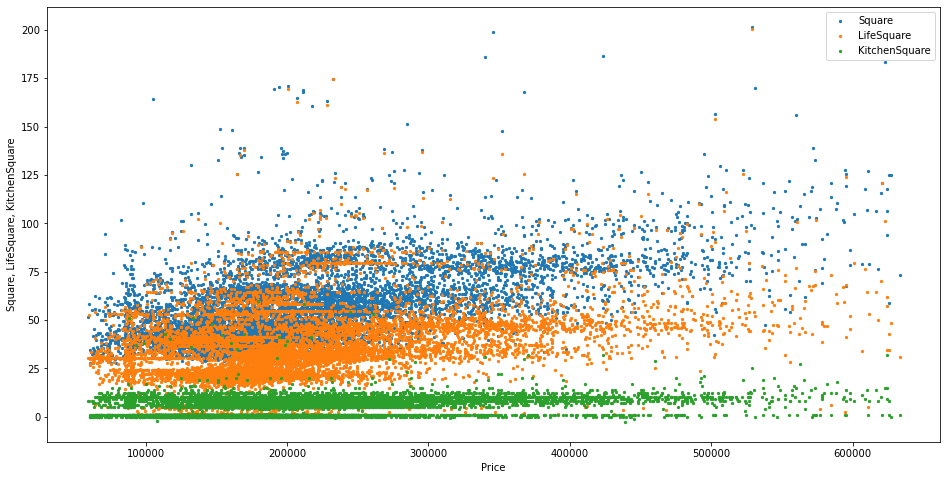

In [1410]:
# Square, LifeSqure, KitchenSquare
TypeSquares = ['Square', 'LifeSquare', 'KitchenSquare'] 

plt.figure(figsize=(16, 8))

for feature in TypeSquares:
    plt.scatter(y_train, X_train[feature], label=feature, s=5)

plt.xlabel('Price')
plt.ylabel('Square, LifeSquare, KitchenSquare')
plt.legend()
plt.show()

### 7. Building a model

In [1411]:
# cv_score = cross_val_score(gb_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
# cv_score

In [1412]:
#cv_score.mean()

In [1413]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

Train R2:	0.9463
Test R2:	0.7806


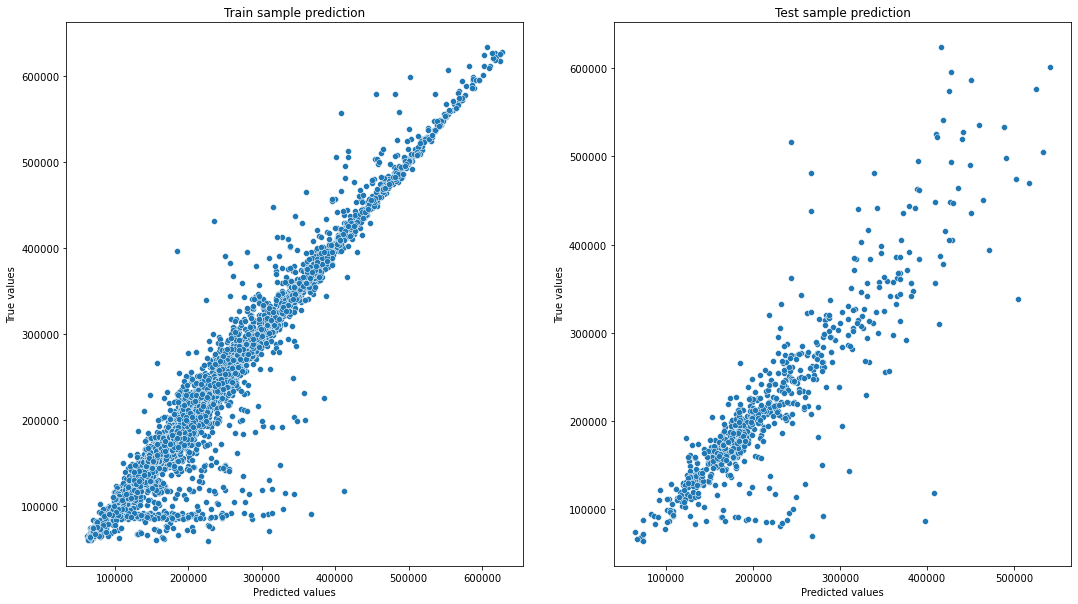

In [1414]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=7,
                                     min_samples_leaf=3,
                                     n_estimators=1690,
                                     max_features='sqrt',
                                     loss='huber',
                                     random_state=42,
                                     learning_rate=0.024
                                    )
# max_depth:        7    , 
# min_samples_leaf: 3    ,
# n_estimators:     1590 ,
# learning_rate:    024  ,
# Train R2:         9388 ,
# Test R2:          771  ,
# Kaggle:           76382,

gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

In [1415]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), columns=['feature_name', 'importance'])
feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.214260
0,Rooms,0.127061
18,DistrictPriceSquare,0.112139
16,PriceKitchen,0.092667
3,LifeSquare,0.070027
20,DistrictSize,0.050627
4,Social_2,0.039495
5,Social_1,0.031599
24,Shops_1Social_3,0.028275
19,PriceRoom,0.026067


### 8. Prediction on test dataset

In [1416]:
test_df.shape

(5000, 26)

In [1417]:
submit = pd.read_csv('./input/real_estate_price_prediction_moscow/sample_submission.csv')

In [1418]:
predictions = gb_model.predict(test_df)
predictions

array([159808.16939082, 117744.6550504 , 132426.77181806, ...,
       148228.08357909, 187419.00396549, 300798.32780302])

In [1419]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,159808.169391
1,5925,117744.655050
2,960,132426.771818
3,3848,88187.916722
4,746,181046.705921


In [1420]:
submit.to_csv('./input/real_estate_price_prediction_moscow/gb_submit.csv', index=False)

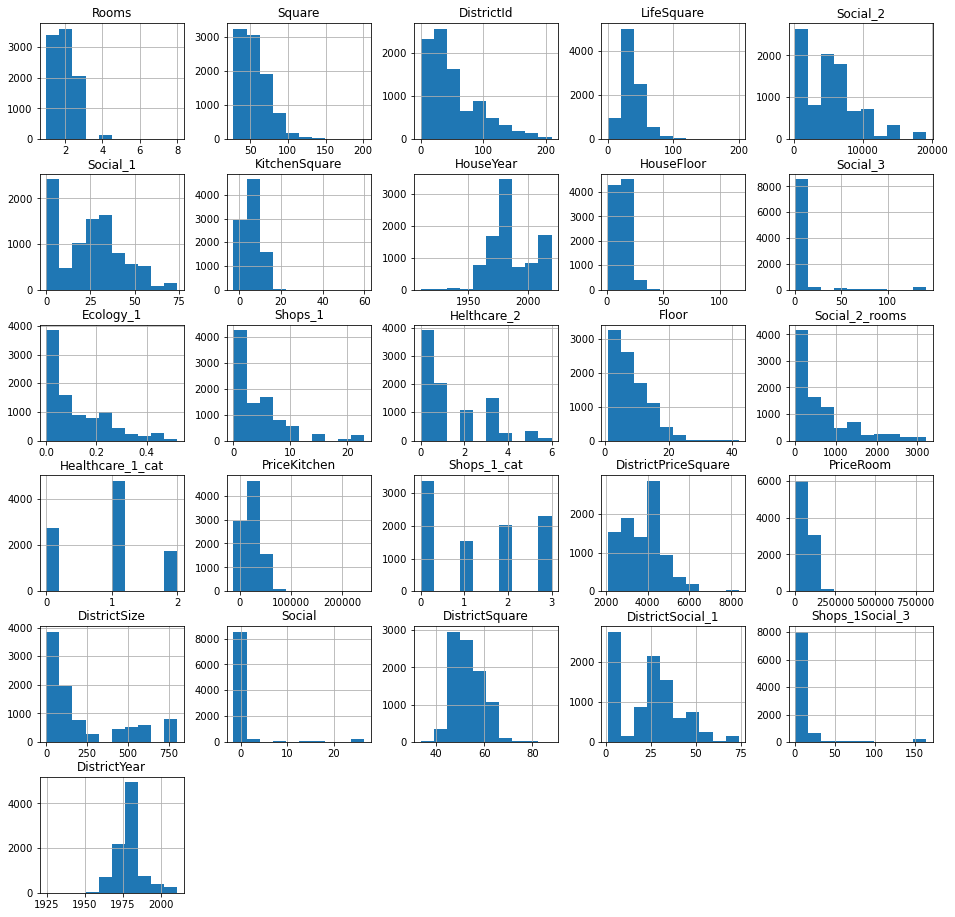

In [1421]:
num_f = list(X_train.select_dtypes(exclude='object').columns)
X_train[num_f].hist(figsize=(16, 16))
plt.show()

In [1422]:
X_train

,Rooms,Square,DistrictId,LifeSquare,Social_2,Social_1,KitchenSquare,HouseYear,HouseFloor,Social_3,...,PriceKitchen,Shops_1_cat,DistrictPriceSquare,PriceRoom,DistrictSize,Social,DistrictSquare,DistrictSocial_1,Shops_1Social_3,DistrictYear
0,1.0,35.919292,46,21.322752,11319,47,6.0,1971,9.0,0,...,26596.816406,2.0,4432.802734,94519.554688,112,-1.602567,46.635628,31.0,5,1971.0
1,2.0,48.851742,21,33.533432,8004,47,5.0,1970,5.0,3,...,19674.876953,2.0,3934.975342,65976.617188,155,-1.009141,46.285423,47.0,8,1970.0
2,3.0,83.260742,1,79.438324,264,1,1.0,2020,21.0,0,...,3012.642334,0.0,3012.642334,79773.085938,609,-1.629113,61.183800,1.0,1,1977.0
3,1.0,38.564732,41,23.375425,10055,36,7.0,1984,17.0,3,...,30030.730469,0.0,4290.104492,100283.015625,82,-1.006236,49.572800,36.0,3,1981.0
4,2.0,53.881481,87,32.887497,7227,43,8.0,1989,17.0,0,...,34539.796875,3.0,4317.474609,70995.468750,26,-1.611045,46.077492,43.0,6,1981.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9294,3.0,79.650436,22,43.927998,6207,30,1.0,1977,20.0,1,...,3862.681152,0.0,3862.681152,56559.949219,74,-1.414414,47.654060,30.0,1,1977.0
9295,3.0,79.953690,1,79.397102,264,1,1.0,1977,17.0,0,...,3012.642334,0.0,3012.642334,79731.695312,609,-1.629113,61.183800,1.0,1,1977.0
9296,1.0,39.698662,11,25.570715,6533,28,7.0,1982,9.0,1,...,29407.482422,2.0,4201.068848,107424.335938,119,-1.413978,48.198669,36.0,6,1973.0
9297,1.0,43.613430,6,3.668460,1564,5,1.0,2016,17.0,0,...,2973.979248,0.0,2973.979248,10909.923828,471,-1.626137,56.571289,5.0,0,1977.0
